In [30]:
#import dependencies library

# the enviornment library
import gym

#the AI framework 
import tensorflow as tf
import tensorflow.keras as keras 
import numpy as np

#just for ploting stuf
import cv2
import matplotlib.pyplot as plt
import tqdm

from collections import deque

After we import dependecies we will creat our enviornment using **gym** library and we chose the brakout game as the playground game to worke on.

In [2]:
# make the environment we chose breakout game to try on.
environment=gym.make("Breakout-v4")

lets explore the environment 

In [5]:
print(environment.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [3]:
# the actions space represent the output of the Neural Network 
action_space=environment.action_space.n
print("The number of action is :({}) and which is the number of output of Neural Network".format(action_space))

The number of action is :(4) and which is the number of output of Neural Network


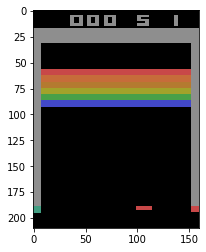

In [5]:
state=environment.reset()
plt.imshow(state)

The First step is make some preprocessing to each frame, where want change the **RGB** format to **gray** fromat and that decrease the confusing in the network and we will cut the top of frame which represent the reword which change and may confuse the training process.

In [31]:
def preprocess_frame(frame):
    """
    this function make preprocessing step for each frame from the game.
    parameter: 
        -frame: is a row frame with [210*64*3] size which provided by the environment, after we make an action that change the world
        the environmnt brovide us by new observation after apply that action.
    return :
        image: processing frame where we cut some of border and keep the play area and change the image to gray scale 
        then resize it to [84,84] shape and finaly normalize pixel value to become in the range [0-1] 
    """
    image=frame[25:-10,5:-5,:]
    image=tf.image.rgb_to_grayscale(image)
    image=tf.image.resize(image,[84,84])
    image=tf.reshape(image,[84,84])
    image=image/255.0
    return image

def ploting_function_one(frame):
    """
    is the same as preprocessing function but we use it for viualization stuf.
    """
    image=frame[25:,:,:]
    image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    image=cv2.resize(image,(84,84))
    return image

In [2]:
class FireResetEnv(gym.Wrapper):
    """
    This class is Warpper where we make sure that the game is runing, becouse in some environment in gym library should 
    start the game by action " 1 " in most of the game so by doing this we make sure that the game is roling.
    """
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
            obs, _, done, _ = self.env.step(2)
            if done:
                self.env.reset()
        return obs

In [ ]:
environment=FireResetEnv(environment)

The above cell containe two preprocessing function one for visulisation becoues we can't plot tensor from tesorflow

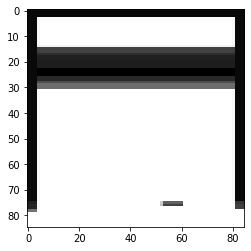

In [100]:
image=ploting_function_one(state)
plt.imshow(image,cmap='binary')

now after we processing the frame we need to stack some frames togather to represent a one state so by using that we can give some information about vilocity.

first leats creat queue with fixed size 4 so after each move we push the frame to the queue and the stack them togather to represent on 3D block the represent the state.

In [7]:
from collections import deque

In [8]:
stacked_blocks=deque(maxlen=4)

In [32]:
def state_creator(frame,is_new_episod,stacked_blocks,number_of_frame=4):
    """
    in this function we stack last 4 frame togather to perform on state and that give us some intuition about vilocity.
    parameter :
        -frame :which is the game observation.
        -is_new_episod: boolean parameter that check if there is no previous frame and that happend in bragning of each episod.
        -stacked_blocks: is deque with maxlength 4 that save the last 4 frame for us.
        -number_of_frame: is by default 4 but we can change it to other number and that make our state more complex.
    return :
        state: tensor with [84,84,4] shape which represent the state of our world.
    """
    if is_new_episod:
        image=preprocess_frame(frame)
        for i in range(number_of_frame):
            stacked_blocks.append(image)
    else:
        image=preprocess_frame(frame)
        stacked_blocks.append(image)
    state=tf.stack(stacked_blocks,axis=2)
    return state

In [33]:
new_state=state_creator(state,True,stacked_blocks)
print("The shape of the frames which is stack togather is : {}".format(new_state.shape))

The shape of the frames which is stack togather is : (85, 85, 4)


Now lets build the model which is convulational Neural Network that contains just 2 layers 

In [12]:
#this model is as recomende from paper "Mnih 2013, Playing Atari with Deep Reinforcement Learning"
keras.backend.clear_session()

model=keras.Sequential([
    keras.layers.Conv2D(16,8,strides=4,padding='valid',activation='relu',input_shape=[84,84,4]),
    keras.layers.Conv2D(32,4,strides=2,padding='valid',activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(action_space)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 43, 43, 16)        4112      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        131104    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819456    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

now we will use replay puffer to collect observation and return batch for training from the buffer by that we reducing the noise and make the learning process much faster using **GPU**

In [13]:
# this represent the memory where we keep the last million state for training.
replay_buffer=deque(maxlen=1000000)

In [25]:
def sample_experiences(batch_size):
    """
    This function is use to sample batch from our memory.
    parameter : 
            -batch size: is numeber of example that provided to our network. 
    return:
            -states:it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
            -actions: it's 2D array [batch_size,action] it's the action in each state in our batch
            -rewards: it's 2D array [batch_size,reward] it's the reward in each state in out batch
            -dones : it's 2D array [batch_size, done ] where done is boolean value help us to compute the target.
            -next_state: it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
    """
    indices=np.random.randint(len(replay_buffer),size=batch_size)
    batch=[replay_buffer[index] for index in indices]
    states,actions,rewords,dones,next_states=[np.array([experiance[field_index] for experiance in batch]) for field_index in range(5)]
    return states,actions,rewords,dones,next_states

In [26]:
def epsilon_greedy_policy(state,epsilon):
    """
    Is the epislon greedy policy whre we use epsilon value to chose an action
    where we want to palance the exploration and explotation as possiable as we can.
    
    we pick random value alpha.
        -if alpha < epsilon : chose random action
         else argmax Q(state) for all action.
    parameter :
        -state: is the current state.
        -epsilon : is the value of threshould between [0,1]
    return :
        the number of action to make 
    
    """
    if np.random.rand()<epsilon:
        return np.random.randint(action_space)
    else:
        Q_values=model.predict(state[np.newaxis])
        return tf.argmax(Q_values[0])

In [1]:
def play_one_step(env,state,epsilon):
    """
    This function make an action and get the observation from the world.
    we make an action and then get the full obesrvation from our environment aplay state_create function to the our 
    observation(frame) and then save it in the memory for training step.
    
    parameter :
        -env: it's represent our world or environment we work on 
        -state : it's the current state.
        -epsilon: it's the thresould we use for action selection
    return :
        next_state: tensore [84,84,4] block represent the last 4 frame.
        reward : it's float number the reward we get after we do some action . 
        done : it's boolean refer if the game finish or not 
        info : it's dictionary have the counter of lives.
    """
    action=epsilon_greedy_policy(state,epsilon)
    next_state,reward,done,info=env.step(action)
    if info['ale.lives']< 5:
            done=True
    stacked_next_state=state_creator(next_state,False,stacked_blocks)
    replay_buffer.append((state,action,reward,done,stacked_next_state))
    return stacked_next_state,reward,done,info

In [28]:
loss_function=tf.losses.mean_squared_error
optimizer=tf.optimizers.Adam(lr=0.00025)

In [29]:
def training_step(batch_size,discount_factor):
    """
    This function is the responsible for doing one training step where we sample one batch from the replay buffer 
    then we push this batch in our model for forward step and apply gradiant with optimizer by hand.
    parameter :
        -batch_size : the number of training example we sample
        dicout_factor: this parameter is responsible for future rewards important it's value must be in range[0-1]
    return :
        None , where it's apply the change inplace for model parameter.
    """
    states,actions,rewards,dones,next_states=sample_experiences(batch_size)
    next_Q_values=model(next_states)
    max_next_Q_values=np.max(next_Q_values,axis=1)
    target_Q_values=rewards+(1-dones)*discount_factor*max_next_Q_values
    
    mask = tf.one_hot(actions, action_space)
    
    with tf.GradientTape() as tape:
        all_Q_values=model(states)
        Q_values=tf.reduce_sum(all_Q_values*mask,axis=1,keepdims=True)
        loss=tf.reduce_mean(loss_function(target_Q_values,Q_values))
    gradiants=tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradiants,model.trainable_variables))

In [ ]:
episodes=700
epsilon=1.0
batch_size=5
discount_factor=0.98

for episode in tqdm.tqdm(range(episodes)):
    state=environment.reset()
    stacked_state=state_creator(state,True,stacked_blocks)
    rewards=0
    epsilon=max(1-episode/500,0.1)
    while True:
        stacked_state,reward,done=play_one_step(environment,stacked_state,epsilon)
        rewards+=reward
        if done:
            if not (episode%10) :
                print(rewards)
            break
            
        if len(replay_buffer)>10:
            training_step(batch_size,discount_factor)

Now lets put all togather in one class 

In [ ]:
class DQN_Agent:
    def __init__(self,environment,model,discount_factor=0.95,learning_rate=0.00025,episode=1000,batch_size=32,replay_size=1000000,staked_frame=4,fixed_epsilon=None,model_checkpoint='DQN_wights.h5',up=25,down=10,left=5,right=5):
        #the environment simulator 
        self.env=environment
        # the model we don't build the model and that give the developer space so he can change the structure of the model.
        self.model=model
        # the discout factor in the Q-learning algorithem
        self.discount_factor=discount_factor
        # the number of episod to run as the number of epochs in supervised learning 
        self.episodes=episode
        
        self.batch_size=batch_size
        # the memory where we save the observations for training 
        self.replay_buffer=deque(maxlen=replay_size)
        # the deque used for state creation where we stacked last 4 frames togather 
        self.stacked_blocks=deque(maxlen=staked_frame)
        # if we want to stack more or less frame togather in other world if we want the state more complex or simpler.
        self.stacked_size=staked_frame
        # if we want the epsilon parameter constant during the training else the parameter will change during the training.
        self.fixed_epsilon=fixed_epsilon
        # the action space it's represent the number neuron in the output layer becouse Q function is maping from state to actions. 
        self.action_space=environment.action_space.n
        # it's rewards list where we save the reward from each episod ( from each epochs )
        self.rewards_list=[]
        # the loss function using to compute the gradiant of the model.
        self.loss_function=tf.losses.mean_squared_error
        # the optimizer using to update the parameter.
        self.optimizer=tf.optimizers.RMSprop(learning_rate=learning_rate,momentum=0.95)
        # it's the file path, where we save the model weights
        self.model_checkpoint=model_checkpoint
        # these four parameter we use for croping the edges of the frame  
        self.up=up
        self.down=-down
        self.left=left
        self.right=-right
        
    
    def _preprocess_frame(self,frame):
        """
        this function make preprocessing step for each frame from the game.
        parameter: 
            -frame: is a row frame with [210*64*3] size which provided by the environment, after we make an action that change the world
            the environmnt brovide us by new observation after apply that action.
        return :
            image: processing frame where we cut some of border and keep the play area and change the image to gray scale 
            then resize it to [84,84] shape and finaly normalize pixel value to become in the range [0-1] 
        """
        # cut the porder and keep the play area
        image=frame[self.up:self.down,self.left:self.right,:]
        image=tf.image.rgb_to_grayscale(image)
        image=tf.image.resize(image,[84,84])
        # reshape becouse it's tensor [84,84,1] and we want [84,84] for make the stacking operation easy
        image=tf.reshape(image,[84,84])
        # normalizing step
        image=image/255.0
        return image
    
    def ploting_function_one(frame):
        """
        is the same as preprocessing function but we use it for viualization stuf.
        """
        image=frame[25:,:,:]
        image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image=cv2.resize(image,(85,85))
        return image
    
    
    def _state_creator(self,frame,is_new_episod):
        """
        this function we stack last 4 frame togather to perform on state and that give us some intuition about vilocity.
        parameter :
            -frame :which is the game observation.
            -is_new_episod: boolean parameter that check if there is no previous frame and that happend in bragning of each episod.
        
        return :
            state: tensor with [84,84,4] shape which represent the state of our world.
        """
        # first preprocessing the frame.
        image=self._preprocess_frame(frame)
        # if it's new episod then stack the first frame four time 
        if is_new_episod:
            for i in range(self.stacked_size):
                self.stacked_blocks.append(image)
                
        # just push the last frame so the first frame get out from the deque
        else:
            self.stacked_blocks.append(image)
            
        # stacked the frames togather in one tensor [84,84,4]
        state=tf.stack(self.stacked_blocks,axis=2)
        
        return state
    
    def _sample_experiences(self):
        """
        This function is use to sample batch from our memory.
        
        return:
            -states:it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
            -actions: it's 2D array [batch_size,action] it's the action in each state in our batch
            -rewards: it's 2D array [batch_size,reward] it's the reward in each state in out batch
            -dones : it's 2D array [batch_size, done ] where done is boolean value help us to compute the target.
            -next_state: it's tensore [batch_size,image_width,image_height,stacked_size] in our case [32,84,84,4]
        """
        # radnom indices from the replay buffer
        indices=np.random.randint(len(self.replay_buffer),size=self.batch_size)
        batch=[self.replay_buffer[index] for index in indices]
        # we combine the experiance togather where the buffer have tuple like this (state,action,reward,done,next_state)
        states,actions,rewords,dones,next_states=[np.array([experiance[field_index] for experiance in batch]) for field_index in range(5)]
        return states,actions,rewords,dones,next_states
    
    
    def _epsilon_greedy_policy(self,state,epsilon):
        """
        Is the epislon greedy policy whre we use epsilon value to chose an action
        where we want to palance the exploration and explotation as possiable as we can.
    
        we pick random value alpha.
            -if alpha < epsilon : chose random action
             else argmax Q(state) for all action.
        parameter :
            -state: is the current state.
            -epsilon : is the value of threshould between [0,1]
        return :
            the number of action to make 
    
        """
        if np.random.rand()<epsilon:
            return np.random.randint(self.action_space)
        else:
            Q_values=self.model.predict(state[np.newaxis])
            return tf.argmax(Q_values[0])
    
    def _play_one_step(self,state,epsilon):
         """
        This function make an action and get the observation from the world.
        we make an action and then get the full obesrvation from our environment aplay state_create function to the our 
        observation(frame) and then save it in the memory for training step.
    
        parameter :
            -state : it's the current state.
            -epsilon: it's the thresould we use for action selection
        return :
            next_state: tensore [84,84,4] block represent the last 4 frame.
            reward : it's float number the reward we get after we do some action . 
            done : it's boolean refer if the game finish or not 
            info : it's dictionary have the counter of lives.
        """
          
        action=self._epsilon_greedy_policy(state,epsilon)
        next_state,reward,done,info=self.env.step(action)
        # we do that becouse we need True done value for computing the target for the model.
        if info['ale.lives']< 5:
            done=True
        stacked_next_state=self._state_creator(next_state,False)
        self.replay_buffer.append((state,action,reward,done,stacked_next_state))
        return stacked_next_state,reward,done,info
    
    def _training_step(self):
        """
        This function is the responsible for doing one training step where we sample one batch from the replay buffer 
        then we push this batch in our model for forward step and apply gradiant with optimizer by hand.
        
        return :
            None , where it's apply the change inplace for model parameter.
        """
        # get the batch from the replay_buffer (our memory)
        states,actions,rewards,dones,next_states=self._sample_experiences()
        #the Q(state,a)=Q(state,a) + alpha [ reward + gamma * max (Q(next_state,a) for all a)-Q(s,a)] 
        next_Q_values=self.model.predict(next_states)
        max_next_Q_values=np.max(next_Q_values,axis=1)
        # compute the target which is [reward +  gamma * max(Q(next_state,a) over a)] 
        # (1-dones) hear refer for the last move (final state) in trajectory so it's should be just the immediat reward becouse there is no next state
        target_Q_values=rewards+(1-dones)*self.discount_factor*max_next_Q_values
        
        #this mask it's important for vanishing the value of actions that we don't used it's 2D array with 1 if action i was picked and zero othewise.
        mask = tf.one_hot(actions, self.action_space)

        #start the gradient recording to compute the gradient for our model.
        with tf.GradientTape() as tape:
            #compute the Q function for state (hear for the whole batch).
            all_Q_values=self.model(states)
            #hear we use the mask so we reduce the result for just the action we picked.
            Q_values=tf.reduce_sum(all_Q_values*mask,axis=1,keepdims=True)
            #computer the loss function with the target we compute erlaier.
            loss=tf.reduce_mean(self.loss_function(target_Q_values,Q_values))
        # compute the gradient for our model parameter.
        gradiants=tape.gradient(loss,self.model.trainable_variables)
        # apply the optimization step using the gradient we compute 
        self.optimizer.apply_gradients(zip(gradiants,self.model.trainable_variables))
        
    def fit(self):
        """
        This function represent the training loop function where we are trying to fit model to produce the best function
        according to the data we have.
        
        """
        for episode in tqdm.tqdm(range(self.episodes)):
            state=self.env.reset()
            stacked_state=self._state_creator(state,True)
            rewards=0
            epsilon=max(1-episode/600,0.1)
            while True:
                stacked_state,reward,done,info=self._play_one_step(stacked_state,epsilon)
                rewards+=reward
                if done :
                    if not (episode%10) and len(self.rewards_list):
                        self.model.save_weights(self.model_checkpoint)
                        print("The best score for last 10 episode is: {} and the worst one is: {}".format(max(self.rewards_list[-10:]),min(self.rewards_list[-10:])))
                    self.rewards_list.append(rewards)
                    break
                # this step to let the replay buffer has some experiance
                if episode>50:
                    self._training_step()

In [ ]:
dqn=DQN_Agent(environment,model)
dqn.fit()